<a href="https://colab.research.google.com/github/armandossrecife/piloto/blob/main/review_31_repositoires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [7]:
!pip3 install gitpython > install_gitpython.log

In [8]:
!sudo apt-get update > apg_get_udate.log

In [9]:
!sudo apt-get install -y cloc > install_cloc.log

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 26.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [19]:
!pip install jira > install_jira.log

In [27]:
!pip install atlassian-python-api > install_atlassian_python_api.log

In [10]:
import pandas as pd
import os
import subprocess
import json
import pandas as pd
import requests
import threading
import datetime
from git import Repo
import csv

class DirectoryAnalyzer:
    def __init__(self, target_directory, cloc_output_file="cloc_output.json"):
        self.target_directory = target_directory
        self.cloc_output_file = cloc_output_file

    def cloc(self):
        os.chdir(self.target_directory)
        try:
            # Run CLOC to analyze the repository and save the output as JSON
            subprocess.run(["cloc", "--json","."], stdout=open(self.cloc_output_file, "w"))
        except Exception as ex:
            print(f'Error: {str(ex)}')


        # Load JSON output from CLOC
        with open(self.cloc_output_file, "r") as json_file:
            cloc_data = json.load(json_file)

        # Extract desired metrics for Java files
        java_metrics = cloc_data.get("Java", {})
        self.total_unique_files = java_metrics.get("nFiles", 0)
        self.total_blank_loc = java_metrics.get("blank", 0)
        self.total_comment_loc = java_metrics.get("comment", 0)
        self.total_loc = java_metrics.get("code", 0)

        sum_metrics = cloc_data.get("SUM", {})
        self.total_nFiles = sum_metrics.get("nFiles",0)
        self.total_LOC_files = sum_metrics.get("code",0)

        return self.total_nFiles, self.total_unique_files, self.total_blank_loc, self.total_comment_loc, self.total_loc, self.total_LOC_files

class RepositoryAnalyzer:
    def __init__(self, target_directory):
        self.target_directory = target_directory

    def get_first_commit_date(self):
        command = ["git", "log", "--reverse", "--format=%ad", "--date=short"]
        result = subprocess.run(command, cwd=self.target_directory, stdout=subprocess.PIPE, text=True)
        self.first_commit_date = result.stdout.splitlines()[0]
        return self.first_commit_date

    def get_last_commit_date(self):
        command = ["git", "log", "-1", "--format=%ad", "--date=short"]
        result = subprocess.run(command, cwd=self.target_directory, stdout=subprocess.PIPE, text=True)
        self.last_commit_date = result.stdout.strip()
        return self.last_commit_date

    def get_total_commit_count(self):
        command = ["git", "rev-list", "--count", "HEAD"]
        result = subprocess.run(command, cwd=self.target_directory, stdout=subprocess.PIPE, text=True)
        self.total_commit_count = int(result.stdout.strip())
        return self.total_commit_count

    def get_total_release_count(self):
        git_tag_command = ["git", "tag"]
        wc_command = ["wc", "-l"]

        git_tag_result = subprocess.run(git_tag_command, cwd=self.target_directory, stdout=subprocess.PIPE, text=True)
        wc_result = subprocess.run(wc_command, input=git_tag_result.stdout, stdout=subprocess.PIPE, text=True)

        self.total_release_count = int(wc_result.stdout.strip())
        return self.total_release_count

def get_repository_name(url):
  repository_name = os.path.splitext(os.path.basename(url))[0]
  return repository_name

def clone_repository(url):
  target_directory = get_repository_name(url)
  subprocess.run(["git", "clone", url, target_directory])

def gera_my_dict(url, total_nFiles, total_unique_files, total_blank_loc, total_comment_loc, total_loc, total_LOC_files):
    name = get_repository_name(url)
    repository_path = '/content/'+name
    git_repo_analyzer = RepositoryAnalyzer(target_directory=repository_path)
    first_commit_date = git_repo_analyzer.get_first_commit_date()
    last_commit_date = git_repo_analyzer.get_last_commit_date()
    total_commit_count = git_repo_analyzer.get_total_commit_count()
    total_release_count = git_repo_analyzer.get_total_release_count()

    my_dict = {
        'name': [name],
        'files': [total_nFiles],
        'java': [total_unique_files],
        'blank_loc_java': [total_blank_loc],
        'comment_loc_java': [total_comment_loc],
        'loc_java': [total_loc],
        'loc_files': [total_LOC_files],
        'first_commit_date':[first_commit_date],
        'last_commit_date':[last_commit_date],
        'total_commit_count':[total_commit_count],
        'total_release_count':[total_release_count]
    }
    return my_dict

def gera_csv(url, my_dict):
  name = get_repository_name(url)
  my_df = pd.DataFrame.from_dict(my_dict)
  name = name + '.csv'
  name = '/content/'+name
  my_df.to_csv(name, index=False)
  return my_df

class RepoCloner:
    def __init__(self, qtd_repositorios, lista_urls):
        self.qtd_repositorios = qtd_repositorios
        self.lista_urls = lista_urls
        self.lista_threads = []
        self.lista_tempo_inicio = []
        self.lista_tempo_conclusao = []

    def my_clone(self, git_url, repo_dir):
        try:
            Repo.clone_from(git_url, repo_dir)
            tempo = datetime.datetime.now()
            print(f'Clonagem do repo {git_url} concluída com sucesso! -> instante: {tempo}')
            elemento = (repo_dir, tempo)
            self.lista_tempo_conclusao.append(elemento)
        except Exception as ex:
            print(f"Erro ao clonar o repo: {git_url} - {str(ex)}")

    def clona_repositorios(self):
        try:
          for i in range(self.qtd_repositorios):
              nome = get_repository_name(url=self.lista_urls[i])
              tdi = threading.Thread(target=self.my_clone, args=(self.lista_urls[i], nome))
              tdi.name = 'Thread-'+str(i+1)
              inicio_thread = datetime.datetime.now()
              print(f"Thread {i+1} iniciada em {inicio_thread} - clonando {nome}:{self.lista_urls[i]}...")
              self.lista_threads.append(tdi)
              elemento = (nome, inicio_thread)
              self.lista_tempo_inicio.append(elemento)
              tdi.start()

          for each in self.lista_threads:
              each.join()
        except Exception as ex:
          print(f'Erro no clona_repositorio: {str(ex)}')

    def mostra_tempo_clonagens(self):
        for t1 in self.lista_tempo_inicio:
            for t2 in self.lista_tempo_conclusao:
                if t1[0] == t2[0]:
                    print(f"Tempo de clonagem do {t1[0]} é: {t2[1]-t1[1]} s")

class CSVFile:
    def __init__(self, file_path):
        self.file_path = file_path

    def read(self):
        with open(self.file_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                yield row

class CSVCombiner:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.accumulated_content = []

    def combine(self):
        for filename in os.listdir(self.folder_path):
            if filename.endswith('.csv'):
                file_path = os.path.join(self.folder_path, filename)
                csv_file = CSVFile(file_path)
                for row in csv_file.read():
                  if 'name' not in row and 'lucene-solr' not in row and 'jackson' not in row:
                      self.accumulated_content.append(row)

    def write(self, output_file_path):
        with open(output_file_path, 'w', newline='') as output_file:
            csv_writer = csv.writer(output_file)
            csv_writer.writerows(self.accumulated_content)

class CSVModifier:
    def __init__(self, csv_file):
        self.csv_file = csv_file

    def insert_new_line(self, new_line):
        existing_content = []
        with open(self.csv_file.file_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                existing_content.append(row)

        existing_content.insert(0, new_line)

        with open(self.csv_file.file_path, 'w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerows(existing_content)

# 31 apache repositories

Selection criteria:

* Project lifetime (in years)
* number of commits
* Number of released releases
* Number of files
* Number of .java files
* Number of participants (contributors)
* Relevance in the open-source community
** Amount of stars

In [16]:
df_30_repositories = pd.read_csv('https://raw.githubusercontent.com/armandossrecife/teste/main/30_repositories.csv')
print(df_30_repositories.info())

list_name_30_repositories = df_30_repositories.nome.to_list()
print(list_name_30_repositories)

list_url_30_repositories = df_30_repositories.url.to_list()
print(list_url_30_repositories)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   nome         30 non-null     object
 1   repositorio  30 non-null     object
 2   url          30 non-null     object
 3   src          30 non-null     object
 4   checa        30 non-null     bool  
dtypes: bool(1), object(4)
memory usage: 1.1+ KB
None
['accumulo', 'calcite', 'cassandra', 'chukwa', 'jackrabbit', 'jackson-databind', 'jspwiki', 'retrofit', 'spring-boot', 'struts', 'elasticsearch', 'jena', 'lucene', 'tika', 'ant-ivy', 'jenkins', 'jgit', 'selenium', 'testng', 'pdfbox', 'poi', 'xerces2-j', 'druid', 'pgjdbc', 'activemq', 'mina', 'libgdx', 'fastjson', 'gson', 'guava']
['https://github.com/apache/accumulo.git', 'https://github.com/apache/calcite.git', 'https://github.com/apache/cassandra.git', 'https://github.com/apache/chukwa.git', 'https://github.com/apache/jackrabbit.git', 'https://githu

## Clone repositories locally

In [17]:
qtd_repositorios = len(list_url_30_repositories)
print(f'Clonando os {qtd_repositorios} repositórios. Aguarde...')
cloner = RepoCloner(qtd_repositorios=len(list_url_30_repositories), lista_urls=list_url_30_repositories)
cloner.clona_repositorios()
cloner.mostra_tempo_clonagens()
print(f'Clonagem de todos os {qtd_repositorios} concluída com sucesso!')

Clonando os 30 repositórios. Aguarde...
Thread 1 iniciada em 2023-09-11 17:44:49.557302 - clonando accumulo:https://github.com/apache/accumulo.git...
Thread 2 iniciada em 2023-09-11 17:44:49.557992 - clonando calcite:https://github.com/apache/calcite.git...
Thread 3 iniciada em 2023-09-11 17:44:49.559474 - clonando cassandra:https://github.com/apache/cassandra.git...
Thread 4 iniciada em 2023-09-11 17:44:49.566439 - clonando chukwa:https://github.com/apache/chukwa.git...
Thread 5 iniciada em 2023-09-11 17:44:49.574147 - clonando jackrabbit:https://github.com/apache/jackrabbit.git...
Thread 6 iniciada em 2023-09-11 17:44:49.577833 - clonando jackson-databind:https://github.com/FasterXML/jackson-databind...
Thread 7 iniciada em 2023-09-11 17:44:49.580196 - clonando jspwiki:https://github.com/apache/jspwiki.git...
Thread 8 iniciada em 2023-09-11 17:44:49.586540 - clonando retrofit:https://github.com/square/retrofit.git...
Thread 9 iniciada em 2023-09-11 17:44:49.590069 - clonando spring-b

## Analyzes CLOC and other metrics for each cloned repository

In [28]:
for each in list_url_30_repositories:
  try:
    URL_REPOSITORY = each
    target_directory = get_repository_name(url=URL_REPOSITORY)
    target_directory = '/content/'+target_directory
    json_file = target_directory + '.json'

    print(f'Analise CLOC diretório: {target_directory}')
    directory_analyzer = DirectoryAnalyzer(target_directory=target_directory, cloc_output_file=json_file)
    total_nFiles, total_unique_files, total_blank_loc, total_comment_loc, total_java_loc, total_files_loc = directory_analyzer.cloc()

    my_dict=gera_my_dict(URL_REPOSITORY,total_nFiles, total_unique_files, total_blank_loc, total_comment_loc, total_java_loc, total_files_loc)

    print(f'Gera o .csv do {URL_REPOSITORY}')
    gera_csv(URL_REPOSITORY,my_dict)
  except Exception as ex:
    print(f'Erro ao fazer a análise CLOC do repositório {each}')

Analise CLOC diretório: /content/accumulo
Gera o .csv do https://github.com/apache/accumulo.git
Analise CLOC diretório: /content/calcite
Gera o .csv do https://github.com/apache/calcite.git
Analise CLOC diretório: /content/cassandra
Gera o .csv do https://github.com/apache/cassandra.git
Analise CLOC diretório: /content/chukwa
Gera o .csv do https://github.com/apache/chukwa.git
Analise CLOC diretório: /content/jackrabbit
Gera o .csv do https://github.com/apache/jackrabbit.git
Analise CLOC diretório: /content/jackson-databind
Gera o .csv do https://github.com/FasterXML/jackson-databind
Analise CLOC diretório: /content/jspwiki
Gera o .csv do https://github.com/apache/jspwiki.git
Analise CLOC diretório: /content/retrofit
Gera o .csv do https://github.com/square/retrofit.git
Analise CLOC diretório: /content/spring-boot
Gera o .csv do https://github.com/spring-projects/spring-boot.git
Analise CLOC diretório: /content/struts
Gera o .csv do https://github.com/apache/struts.git
Analise CLOC dir

In [29]:
!rm -rf /content/temp  && mkdir /content/temp
!cp /content/*.csv /content/temp

In [30]:
!ls -liath /content/temp

total 128K
  28871 drwxr-xr-x 2 root root 4.0K Sep 11 18:58 .
  29189 -rw-r--r-- 1 root root  216 Sep 11 18:58 xerces2-j.csv
  29167 -rw-r--r-- 1 root root  229 Sep 11 18:58 elasticsearch.csv
  29168 -rw-r--r-- 1 root root  217 Sep 11 18:58 fastjson.csv
  29169 -rw-r--r-- 1 root root  207 Sep 11 18:58 gson.csv
  29170 -rw-r--r-- 1 root root  215 Sep 11 18:58 guava.csv
  29171 -rw-r--r-- 1 root root  220 Sep 11 18:58 jackrabbit.csv
  29172 -rw-r--r-- 1 root root  225 Sep 11 18:58 jackson-databind.csv
  29173 -rw-r--r-- 1 root root  215 Sep 11 18:58 jena.csv
  29174 -rw-r--r-- 1 root root  218 Sep 11 18:58 jenkins.csv
  29175 -rw-r--r-- 1 root root  213 Sep 11 18:58 jgit.csv
  29176 -rw-r--r-- 1 root root  214 Sep 11 18:58 jspwiki.csv
  29177 -rw-r--r-- 1 root root  215 Sep 11 18:58 libgdx.csv
  29178 -rw-r--r-- 1 root root  218 Sep 11 18:58 lucene.csv
  29179 -rw-r--r-- 1 root root  207 Sep 11 18:58 mina.csv
  29180 -rw-r--r-- 1 root root  215 Sep 11 18:58 pdfbox.csv
  29181 -rw-r--r-- 

### Merge all .csv

In [31]:
folder_path = '/content/temp'
output_file_path = '/content/temp/combined.csv'
csv_combiner = CSVCombiner(folder_path)
csv_combiner.combine()
csv_combiner.write(output_file_path)

csv_file_path = '/content/temp/combined.csv'
new_line = ['name','files','java','blank_loc_java','comment_loc_java','loc_java','loc_files','commit_inicial','commit_final','qtd_commits','qtd_releases']
csv_file = CSVFile(csv_file_path)
csv_modifier = CSVModifier(csv_file)
csv_modifier.insert_new_line(new_line)

### Generates the Dataframe of the CLOC analyzes of the repositories

In [32]:
df_cloc_repositories = pd.read_csv('/content/temp/combined.csv')

df_cloc_repositories['commit_inicial'] = pd.to_datetime(df_cloc_repositories['commit_inicial'])
df_cloc_repositories['commit_final'] = pd.to_datetime(df_cloc_repositories['commit_final'])

# Calculate the difference in years
df_cloc_repositories['life_span'] = (df_cloc_repositories['commit_final'] - df_cloc_repositories['commit_inicial']).dt.days / 365

In [49]:
df_temp1 = df_cloc_repositories[['name','files','loc_files','java','loc_java','qtd_commits','qtd_releases','life_span']].copy()
df_temp1.sort_values(by='name', inplace=True)

df_temp2 = pd.read_csv('https://raw.githubusercontent.com/armandossrecife/teste/main/30_repositories.csv')
df_temp2.sort_values(by='nome', inplace=True)

In [50]:
l1 = df_temp1.name.to_list()
l2 = df_temp1.files.to_list()
l3 = df_temp1.loc_files.to_list()
l4 = df_temp1.java.to_list()
l5 = df_temp1.loc_java.to_list()
l6 = df_temp1.qtd_commits.to_list()
l7 = df_temp1.qtd_releases.to_list()
l8 = df_temp1.life_span.to_list()
l9 = df_temp2.url.to_list()
l10 = df_temp2.nome.to_list()
l11 = df_temp2.src.to_list()
l12 = df_temp2.stars.to_list()
l13 = df_temp2.forks.to_list()
l14 = df_temp2.colaborators.to_list()

In [51]:
df_temp3 = pd.DataFrame({'name':l1,'url':l9, 'files':l2,'loc_files':l3,'java':l4,'loc_java':l5,'qtd_commits':l6,'qtd_releases':l7,'life_span':l8, 'source_java':l11, 'stars':l12, 'forks':l13, 'colaborators':l14})
df_temp3

,name,url,files,loc_files,java,loc_java,qtd_commits,qtd_releases,life_span,source_java,stars,forks,colaborators
0,accumulo,https://github.com/apache/accumulo.git,2217,442081,2058,393203,12042,44,11.917808,core/src/main/java,995,434,152
1,activemq,https://github.com/apache/activemq.git,4927,466389,4360,416725,11476,85,17.753425,activemq-http/src/main/java,2200,1400,128
2,ant-ivy,https://github.com/apache/ant-ivy.git,1869,316568,664,77786,3048,23,18.189041,src/java,60,117,21
3,calcite,https://github.com/apache/calcite.git,2619,469625,2321,407510,5401,113,11.328767,core/src/main/java,4000,2100,325
4,cassandra,https://github.com/apache/cassandra.git,4998,1055561,4459,680827,29142,297,14.536986,src/java,8200,3500,426
5,chukwa,https://github.com/apache/chukwa.git,781,104693,469,42874,854,26,10.638356,core/src/main/java,82,44,10
6,druid,https://github.com/apache/druid.git,10356,2404163,7571,1081801,13174,486,10.890411,server/src/main/java,12800,3600,564
7,elasticsearch,https://github.com/elastic/elasticsearch.git,23674,3254155,18385,2675287,71870,369,13.597260,server/src/main/java,65100,2700,1862
8,fastjson,https://github.com/alibaba/fastjson.git,3192,208569,3119,186876,3983,134,11.789041,src/main/java,25400,6600,179
9,gson,https://github.com/google/gson.git,291,36612,249,33372,1877,47,15.035616,gson/src/main/java,22400,4300,142


In [41]:
df_estatistica_repos = round(df_temp3.describe(),2)
df_estatistica_repos

,files,loc_files,java,loc_java,qtd_commits,qtd_releases,life_span,stars,forks,colaborators
count,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00
mean,3867.40,515158.13,2982.80,362654.73,13972.97,203.57,15.40,12986.23,3769.50,293.93
std,4556.07,690314.98,3548.21,505661.18,15787.43,305.82,4.05,19667.25,7366.59,390.42
min,291.00,25305.00,249.00,23633.00,854.00,23.00,7.64,35.00,23.00,3.00
25%,1292.75,167144.75,913.00,101326.25,5131.50,77.50,11.82,987.50,482.75,35.75
50%,2531.50,326438.00,1983.50,186135.00,8419.00,99.50,15.32,2050.00,901.50,161.00
75%,4547.75,499655.00,3561.25,406016.50,13057.50,208.25,17.71,21775.00,4125.00,326.50
max,23674.00,3254155.00,18385.00,2675287.00,71870.00,1688.00,26.08,69300.00,39400.00,1862.00


<Axes: >

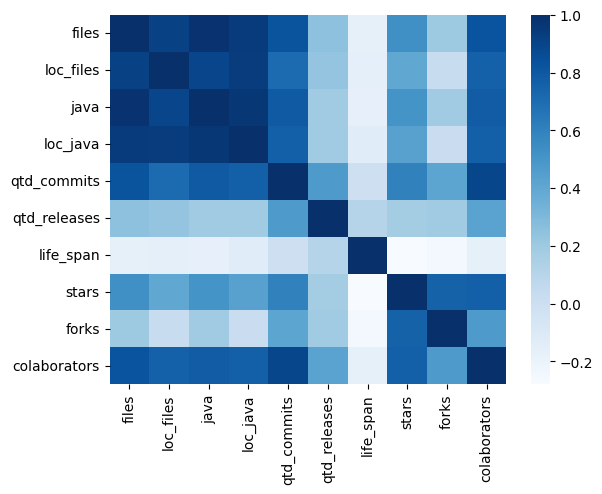

In [42]:
import seaborn as sns

# calculate the correlation matrix on the numeric columns
corr = df_temp3.select_dtypes('number').corr()

sns.heatmap(corr, cmap='Blues')

In [48]:
df_temp3.to_csv('/content/30_repositories_complete.csv', index=False)